In [2]:
import os
from PIL import Image
import numpy as np
from numpy import save, load
import IPython.display
from collections import OrderedDict
from sklearn.preprocessing import StandardScaler
import umap
import umap.plot
import seaborn as sns
import torch
import skimage
from pkg_resources import packaging
import clip
import pandas as pd
import re
import matplotlib.pyplot as plt
import ipywidgets as widgets
from ipywidgets import interact
from ipywidgets import Layout

import math
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn import preprocessing


%matplotlib inline
%config InlineBackend.figure_format = 'retina'

# 1. Basic embedding and image classification to illustrate CLIP's zero-shot capabilities

In [6]:
### Load DIRTI supplementary data
df = pd.read_excel('DIRTI_Supplementary.xlsx')
df['categorie'] = df.loc[:, 'name']

# Make last column first
cols = list(df.columns)
cols = [cols[-1]] + cols[:-1]
df = df[cols]

# Create new column containing only category name
df['categorie'].replace(to_replace=r'(\d*)_food', value='food', regex=True, inplace=True)
df['categorie'].replace(to_replace=r'(\d*)_food neutral', value='food', regex=True, inplace=True)
df['categorie'].replace(to_replace=r'(\d*)_animals', value='animals', regex=True, inplace=True)
df['categorie'].replace(to_replace=r'(\d*)_animals neutral', value='animals', regex=True, inplace=True)
df['categorie'].replace(to_replace=r'(\d*)_body_products', value='body_products', regex=True, inplace=True)
df['categorie'].replace(to_replace=r'(\d*)_body_products neutral', value='body_products', regex=True, inplace=True)
df['categorie'].replace(to_replace=r'(\d*)_injuries_infections', value='injuries_infections', regex=True, inplace=True)
df['categorie'].replace(to_replace=r'(\d*)_injuries_infections neutral', value='injuries_infections', regex=True, inplace=True)
df['categorie'].replace(to_replace=r'(\d*)_death', value='death', regex=True, inplace=True)
df['categorie'].replace(to_replace=r'(\d*)_death neutral', value='death', regex=True, inplace=True)
df['categorie'].replace(to_replace=r'(\d*)_hygiene', value='hygiene', regex=True, inplace=True)
df['categorie'].replace(to_replace=r'(\d*)_hygiene neutral', value='hygiene', regex=True, inplace=True) 

In [7]:
### Drop 'neutral', didn't work as expected at last step
df['categorie'].replace(to_replace=r'food neutral', value='food', regex=True, inplace=True)
df['categorie'].replace(to_replace=r'animals neutral', value='animals', regex=True, inplace=True)
df['categorie'].replace(to_replace=r'body_products neutral', value='body_products', regex=True, inplace=True)
df['categorie'].replace(to_replace=r'injuries_infections neutral', value='injuries_infections', regex=True, inplace=True)
df['categorie'].replace(to_replace=r'death neutral', value='death', regex=True, inplace=True)
df['categorie'].replace(to_replace=r'hygiene neutral', value='hygiene', regex=True, inplace=True) 

In [8]:
### Label enconding of categories
df['num_cat'] = df.categorie.map({'food':0, 'animals':1, 'body_products':2, 'injuries_infections':3, 'death':4, 'hygiene':5})

In [ ]:
### Model choice, image preprocessing, feature extraction and label prediction
### This step was completed on a separate machine with a more powerful GPU/CPU

# Check torch version
print("Torch version:", torch.__version__)

# Check list of CLIP models
clip.available_models()

# This is a model with the transformer
model, preprocess = clip.load("ViT-B/32")

# This is the ResNet 50 they used in the online microscope
# model, preprocess = clip.load("RN50x64")

# Check parameters
model.cuda().eval()
input_resolution = model.visual.input_resolution
context_length = model.context_length
vocab_size = model.vocab_size

print("Model parameters:", f"{np.sum([int(np.prod(p.shape)) for p in model.parameters()]):,}")
print("Input resolution:", input_resolution)
print("Context length:", context_length)
print("Vocab size:", vocab_size)

# Get images and their names
stim_names = []
original_images []
images = []

for i in os.listdir('/home/eclips/Documents/DeepProjections/DIRTI'):
    stim_names.append(i)
stim_names.sort()

for i in stim_names:
    original_images.append(Image.open('/home/eclips/Documents/DeepProjections/DIRTI/'+i).convert("RGB"))
    images.append(preprocess(Image.open('/home/eclips/Documents/DeepProjections/DIRTI/'+i).convert("RGB")))

# Make tensor out of images
image_input = torch.tensor(np.stack(images)).cuda()

# Extract image features
with torch.no_grad():
    image_features = model.encode_image(image_input).float()
    
# Create image labels and descriptions to be tokenized
# There are two descriptions variants, one for basic zero-shot classification;
# and the other for the 'disgust' related part
categories = ['food', 'animals','body products','injuries/infections','death','hygiene']
adjectives = ['disgusting', '']
descriptions = [f"This is a photo of {label}" for label in categories]
disg_descriptions = [f"This is a {adj} photo of {label}" for adj in adjectives for label in categories]
text_tokens = clip.tokenize(descriptions).cuda()

# Extract text features
with torch.no_grad():
    text_features = model.encode_text(text_tokens).float()
    text_features /= text_features.norm(dim=-1, keepdim=True)

# Make top 5 label prediction for every image
text_probs = (100.0 * image_features @ text_features.T).softmax(dim=-1)
top_probs, top_labels = text_probs.cuda().topk(5, dim=-1)

# Print predictions and probabilities
print(top_probs)
print(top_labels)

# Save image features
np.save('image_features.npy', image_features)

In [4]:
# Transfer image_features to cpu and apply StandardScaler()

# new_image_features = torch.Tensor.cpu(image_features)
image_features = load('scaled_image_features.npy')
scaled_image_features = StandardScaler().fit_transform(image_features)

In [9]:
#### Fit UMAP to the scaled_image_features and create interactive visualization

# This is just to make sure the plot shows up in the notebook
umap.plot.output_notebook()

# This is where the UMAP is applied and plotted
mapper = umap.UMAP().fit(scaled_image_features)

hover_data = pd.DataFrame({'index':np.arange(300),
                           'label': df.categorie[:300]})
hover_data['item'] = hover_data.label.map(
    {
        '0':'animals',
        '1':'animals neutral',
        '2':'body products',
        '3':'body products neutral',
        '4':'death',
        '5':'death neutral',
        '6':'food',
        '7':'food neutral',
        '8':'hygiene',
        '9':'hygiene neutral',
        '10':'injuries infections', 
        '11':'injuries infections neutral'
    }
)
p = umap.plot.interactive(mapper, labels=df.categorie[:300], hover_data=hover_data, point_size=10)
umap.plot.show(p)

Loading BokehJS ...

In [12]:
stim_names = []

for i in os.listdir('/Users/shwnmnl/Documents/Stimuli/DIRTI/DIRTI Database'):
    stim_names.append(i)
    
stim_names.sort()

images = []

for i in stim_names:
    try:
        images.append(Image.open('/Users/shwnmnl/Documents/Stimuli/DIRTI/DIRTI Database/'+i).convert("RGB"))
    except IsADirectoryError:
        continue

In [13]:
### This is a widget that lets you scroll through the images

def browse_images(digits):
    n = len(images)
    def view_image(i):
        plt.imshow(images[i], interpolation='nearest')
        plt.title('DIRTI Image: %s' % i)
        plt.show()
    interact(view_image, i=(0,n-1))
browse_images(images)

interactive(children=(IntSlider(value=149, description='i', max=299), Output()), _dom_classes=('widget-interac…

In [145]:
### We're now ready to try a KNN classification on the basic embedding 
### (which doesn't contain any disgust related info, only the category names)

# Label encode the categories
# df["categorie"] = df["categorie"].astype('category')
# df["num_cat"] = df["categorie"].cat.codes

# Apply Dim. Reduct.
reducer = umap.UMAP()
embedding = reducer.fit_transform(scaled_image_features)

# Get the data and model ready
num_folds = 10
seed = 42
kfold = KFold(n_splits=num_folds, random_state=seed, shuffle=True)
model = KNeighborsClassifier(n_neighbors=6, metric='euclidean')
X_train, X_test, y_train, y_test = train_test_split(embedding, df['num_cat'], random_state=seed, test_size=0.3)
Z_train = StandardScaler().fit_transform(X_train)
Z_test = StandardScaler().fit_transform(X_test)

# Fit model, predict and print result
model.fit(Z_train,y_train)
y_pred = model.predict(Z_test)
print(f'Accuracy score: {metrics.accuracy_score(y_test,y_pred)}')

Accuracy score: 0.8


Minimum error:  0.18888888888888888 at k = 4
Maximum accuracy:  0.8111111111111111 at k = 4


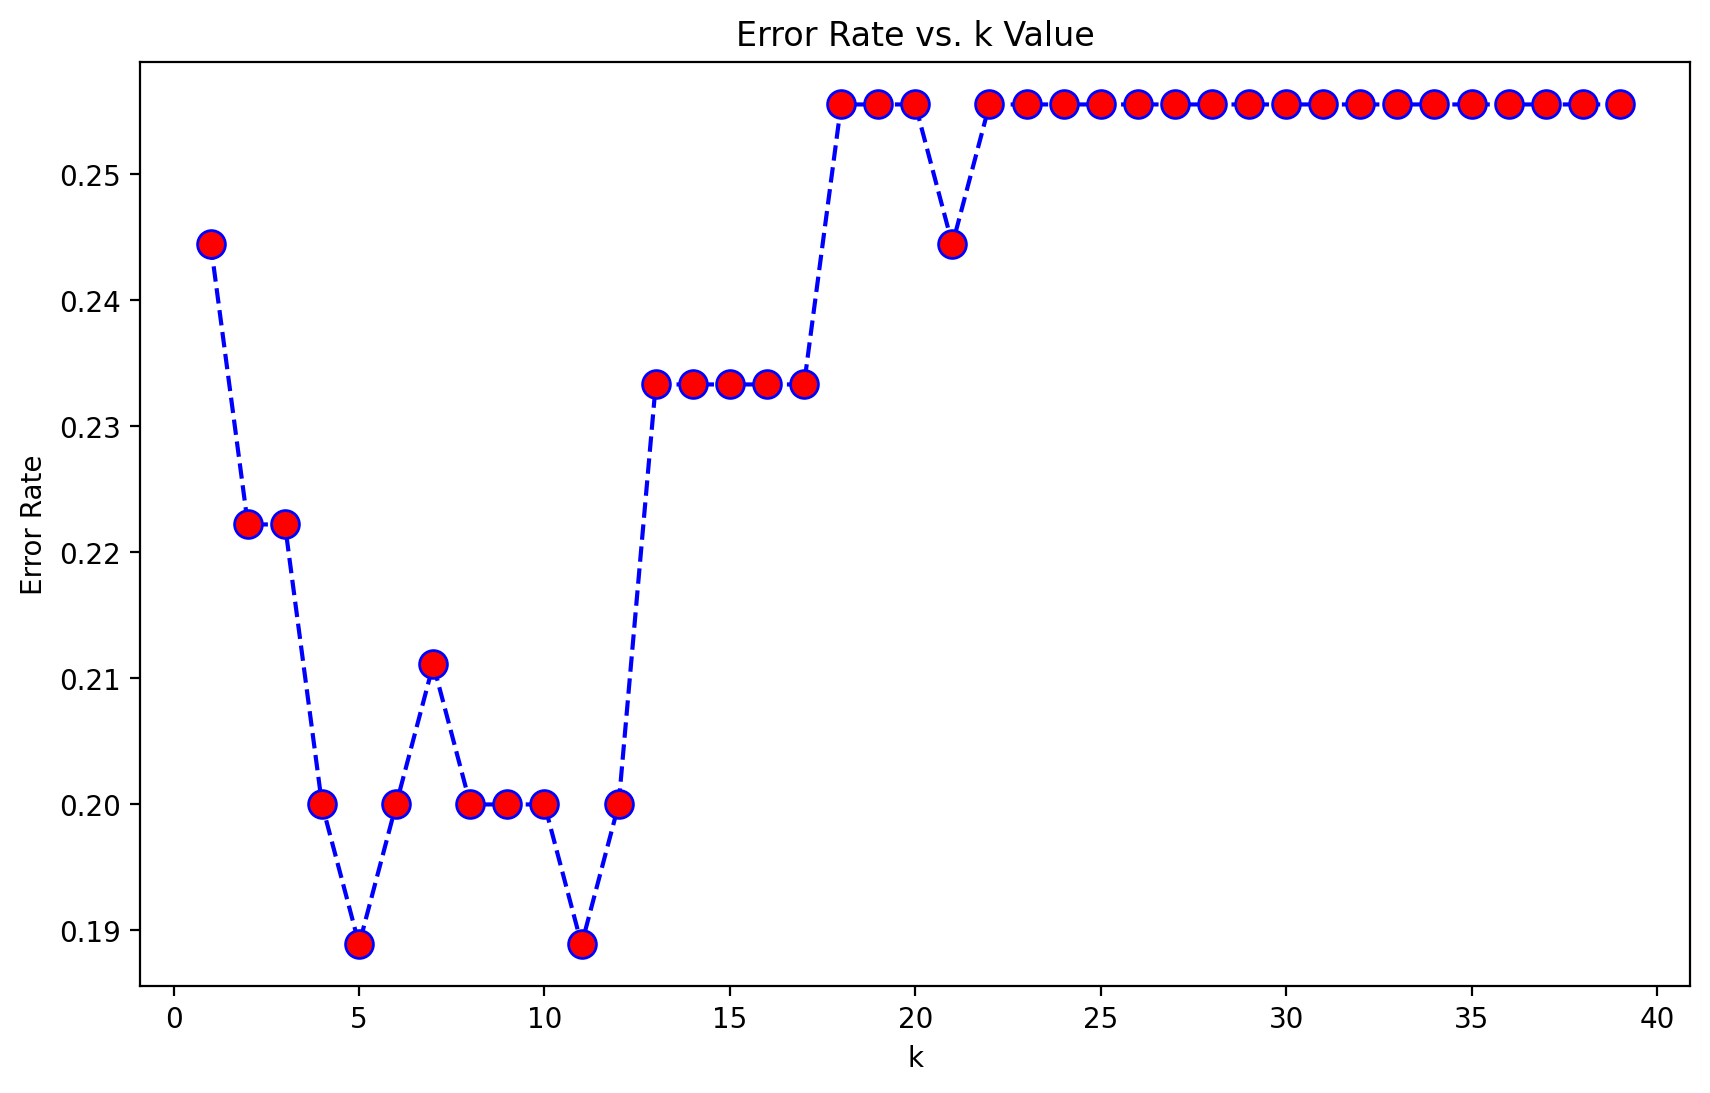

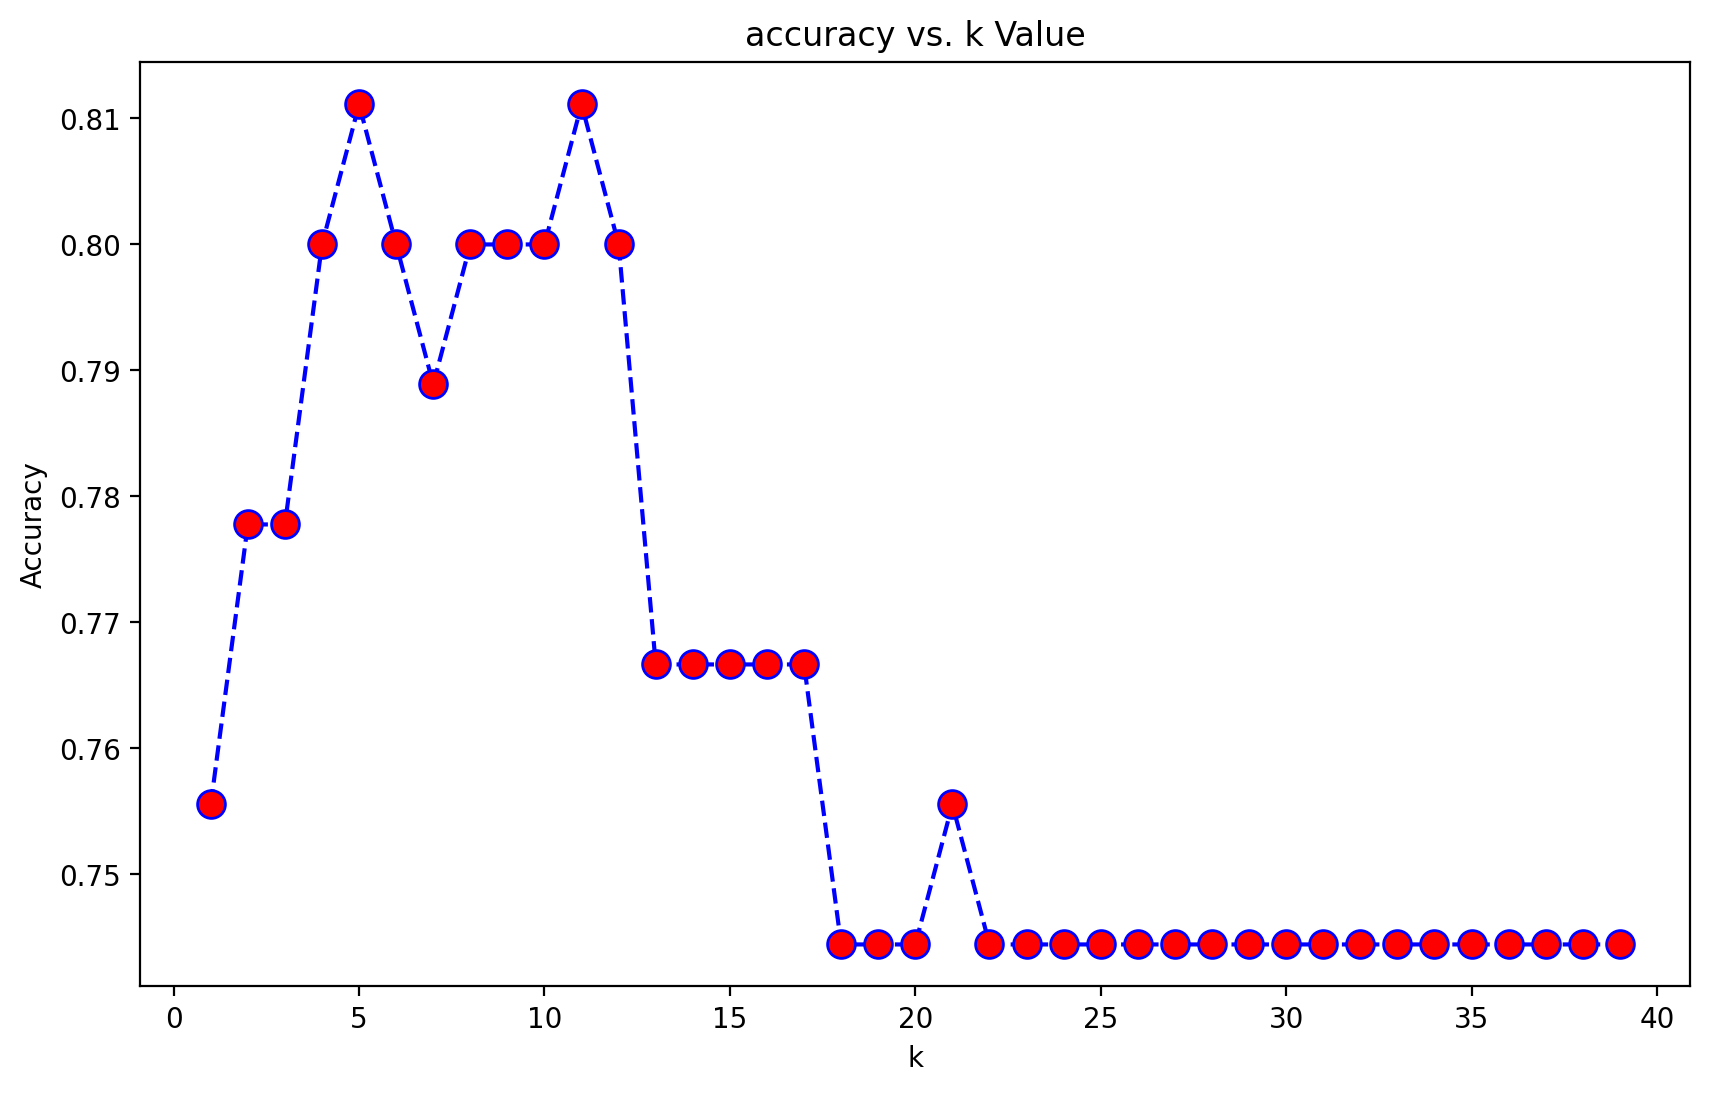

In [147]:
### Plots for error rate and accuracy for k = 1 to 40

# Error
error_rate = []
for i in range(1,40):
    knn = KNeighborsClassifier(n_neighbors=i, p=2, metric='euclidean')
    knn.fit(Z_train,y_train)
    pred_i = knn.predict(Z_test)
    error_rate.append(np.mean(pred_i != y_test))

plt.figure(figsize=(10,6))
plt.plot(range(1,40),error_rate,color='blue', linestyle='dashed', 
         marker='o',markerfacecolor='red', markersize=10)
plt.title('Error Rate vs. k Value')
plt.xlabel('k')
plt.ylabel('Error Rate')
print("Minimum error: ",min(error_rate),"at k =",error_rate.index(min(error_rate)))

# Accuracy
acc = []
for i in range(1,40):
    neigh = KNeighborsClassifier(n_neighbors = i).fit(Z_train,y_train)
    yhat = neigh.predict(Z_test)
    acc.append(metrics.accuracy_score(y_test, yhat))
    
plt.figure(figsize=(10,6))
plt.plot(range(1,40),acc,color = 'blue',linestyle='dashed', 
         marker='o',markerfacecolor='red', markersize=10)
plt.title('accuracy vs. k Value')
plt.xlabel('k')
plt.ylabel('Accuracy')
print("Maximum accuracy: ",max(acc),"at k =",acc.index(max(acc)))

# Ecologically motivated (disgusting) prompt engineering, embedding and prediction

In [ ]:
### Here we reran this part of the precedent code to get new text features and top 5 label predictions

categories = ['food', 'animals','body products','injuries/infections','death','hygiene']
adjectives = ['disgusting', '']
# descriptions = [f"This is a photo of {label}" for label in categories]
disg_descriptions = [f"This is a {adj} photo of {label}" for adj in adjectives for label in categories]
text_tokens = clip.tokenize(disg_descriptions).cuda()

# Extract text features
with torch.no_grad():
    text_features = model.encode_text(text_tokens).float()
    text_features /= text_features.norm(dim=-1, keepdim=True)

# Make top 5 label prediction for every image
text_probs = (100.0 * image_features @ text_features.T).softmax(dim=-1)
top_probs, top_labels = text_probs.cuda().topk(5, dim=-1)

# Print predictions and probabilities
print(top_probs)
print(top_labels)

np.save('disg_top_labels.npy', top_labels)

In [148]:
### Load label predictions
disg_top_labels = load('disg_top_labels.npy')

In [151]:
### This part is label encoding rows where the average disgust score was >=5
### Indexes where found using:
### df.index[df['disg_mean_all'] >= 5].tolist()

# Food
for i in [0,1,2,4,6,8,10,12,14,22,25,28,31,33,37,39]:
    df['num_cat'][i] = 6

# Body_Products
for i in [111,115,117,118,119,130,133,134,137,138,139]:
    df['num_cat'][i] = 8

# Injuries
for i in [159,164,177]:
    df['num_cat'][i] = 9

# Death
for i in [201,202,204,208,210,213,214,222,224,230,231,237,239]:
    df['num_cat'][i] = 10

# Hygiene
for i in [257, 270, 275]:
    df['num_cat'][i] = 11

/var/folders/fb/tx890psd65zdxmvrlxh9dzq40000gn/T/ipykernel_1826/2785493798.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['num_cat'][i] = 6


# Calculate accuracy score for label predictions based on ecologically motivated prompt engeneering
## Interestingly, using the second prediction for all images yielded a better accuracy, demonstrating the importance of varying the text embeddings to capture more information

In [165]:
metrics.accuracy_score(disg_top_labels[:,0], df['num_cat'])

0.16333333333333333

In [164]:
metrics.accuracy_score(disg_top_labels[:,1], df['num_cat'])

0.3466666666666667